# Case 5 - Proxy Estimation (SC~Tritium)
Welcome to the demonstration notebook where we'll estimate the tritium using Specific Conductance as a Proxy using the **pylenm** package!<br>
Let’s get started!

## Setup
Make sure to install pylenm from https://pypi.org/project/pylenm/ by running `pip install pylenm` in your environment terminal. Once completed, you should be able to import the package. Note: to update to the latest version of pylenm run: `pip install pylenm --upgrade`

In [1]:
# pip install pylenm
# pip install pyproj
# pip install rasterio
# pip install elevation
# pip install richdem       # this only works for python <= 3.10

In [2]:
# Basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from math import sqrt
from sklearn.metrics import r2_score

# # pylenm
# import pylenm
# print("pylenm version: ", pylenm.__version__)
# from pylenm import PylenmDataFactory

# pylenm2
import pylenm2
print("pylenm2 version: ", pylenm2.__version__)
from pylenm2 import PylenmDataModule

# GIS data layers
from pyproj import Transformer, CRS
import rasterio
import elevation
import richdem as rd

plt.rcParams["font.family"] = "Times New Roman"

pylenm2 version:  2.0


In [3]:
# Load GIS elevation data
# UNCOMMENT THE 2 LINES BELOW IF YOU DO NOT HAVE THE DEM FILE ALREADY
# dem_path = os.path.join(os.getcwd(), 'FArea-30m-DEM_cropped.tif')
# elevation.clip(bounds=(-81.6855, 33.2657, -81.6734, 33.2785), output=dem_path)

# IF YOU DO HAVE THE DEM FILE ALREADY
dem_path = "./data/FArea-30m-DEM_cropped.tif"


farea_dem = rd.LoadGDAL(dem_path)
farea_ras = rasterio.open(dem_path)

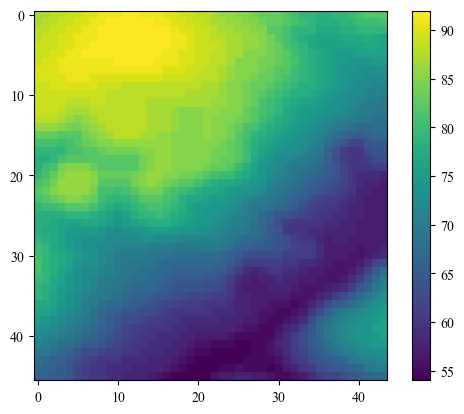

In [4]:
plt.imshow(farea_dem, interpolation='none')
plt.colorbar()
plt.show()

In [5]:
crs = CRS.from_epsg("26917")
proj = Transformer.from_crs(crs.geodetic_crs, crs)

x_loc = np.zeros([farea_ras.height, farea_ras.width])
y_loc = np.zeros([farea_ras.height, farea_ras.width])
for i in range(farea_ras.height):
  for j in range(farea_ras.width):
    lon = farea_ras.xy(i,j)[0]
    lat = farea_ras.xy(i,j)[1]
    utm_x, utm_y =proj.transform(lat,lon) # Latitude/Longitude to UTM
    x_loc[i,j] = utm_x
    y_loc[i,j] = utm_y

In [6]:
slope = rd.TerrainAttribute(farea_dem, attrib='slope_riserun')
accum = rd.FlowAccumulation(farea_dem, method='D8')
twi   = np.log(accum/slope)


A/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_23401/3896729822.py:3: RuntimeWarning: divide by zero encountered in divide
  twi   = np.log(accum/slope)
 Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0004445=====================  ] (97% - 0.0s - 1 threads)

A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[================================================= ] (99% - 0.0s - 1 threads)s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 830
p Calculating flow accumulation...
t Wall-time       = 0.000921458 s============ ] (99% - 0.0s - 1 threads)


## Load Well Time Series Data + Preprocess

In [7]:
from pylenm2.data import filters

# Load and process well time-series data
# url_1 = 'https://raw.githubusercontent.com/ALTEMIS-DOE/pylenm/master/notebooks/data/FASB_Data_thru_3Q2015_Reduced_Demo.csv'
# url_2 = 'https://github.com/ALTEMIS-DOE/pylenm/blob/master/notebooks/data/FASB%20Well%20Construction%20Info.xlsx?raw=true'

url_1 = './data/FASB_Data_thru_3Q2015_Reduced_Demo.csv'
url_2 = './data/FASB Well Construction Info.xlsx'

concentration_data = pd.read_csv(url_1)
construction_data = pd.read_excel(url_2)
pylenm2_dm = PylenmDataModule(concentration_data)
filters.simplify_data(data=pylenm2_dm, inplace=True)
pylenm2_dm.set_construction_data(construction_data)

/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_23401/603169083.py:10: DtypeWarning: Columns (15,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  concentration_data = pd.read_csv(url_1)


Successfully imported the data!



Data summary for water table

In [8]:
from pylenm2.data import fetchers

analyte = 'TRITIUM'
tr_details = fetchers.get_analyte_details(
    data_pylenm_dm=pylenm2_dm, 
    analyte_name=analyte,
)
tr_details

,Start Date,End Date,Date Range (days),Unique samples
Station Name,,,,
FSB 77,1990-01-01,2006-10-16,6132,65
FSB111C,1990-01-01,2006-10-17,6133,67
FSB105C,1990-01-01,2006-10-19,6135,67
FSB111D,1990-01-01,2006-10-26,6142,68
FSB107D,1990-01-01,2007-02-01,6240,68
...,...,...,...,...
FSB146D,2015-04-29,2015-09-09,133,9
FSB145D,2015-04-30,2015-09-09,132,9
FSB143D,2015-05-04,2015-09-09,128,9


Select wells that have enough and recent samples

In [9]:
n_samples = tr_details['Unique samples']
end_date = tr_details['End Date']
start_date = tr_details['Start Date']
well_names  = tr_details.index
well_enough = well_names[n_samples>20]

In [10]:
well_recent = well_names[
    end_date> datetime.strptime('2015-01-01', '%Y-%m-%d').date(),
]
well_old = well_names[
    start_date< datetime.strptime('2006-01-01', '%Y-%m-%d').date(),
]

Temporal interpolation of the time series at equal frequency

In [11]:
from pylenm2.data import transformation

tr_interp = transformation.interpolate_stations_by_analyte(
    data_pylenm_dm=pylenm2_dm, 
    analyte='TRITIUM', 
    frequency='1M', 
    rm_outliers=True, 
    z_threshold=3,
)
sc_interp = transformation.interpolate_stations_by_analyte(
    data_pylenm_dm=pylenm2_dm, 
    analyte='SPECIFIC CONDUCTANCE', 
    frequency='1M', 
    rm_outliers=True, 
    z_threshold=3,
)

tr_interp.index = pd.to_datetime(tr_interp.index)
sc_interp.index = pd.to_datetime(sc_interp.index)

tr_interp[tr_interp <= 0] = 0.001
sc_interp[sc_interp <= 0] = 0.001

Select the upper aquifer wells and the wells that have enough samples

44 wells


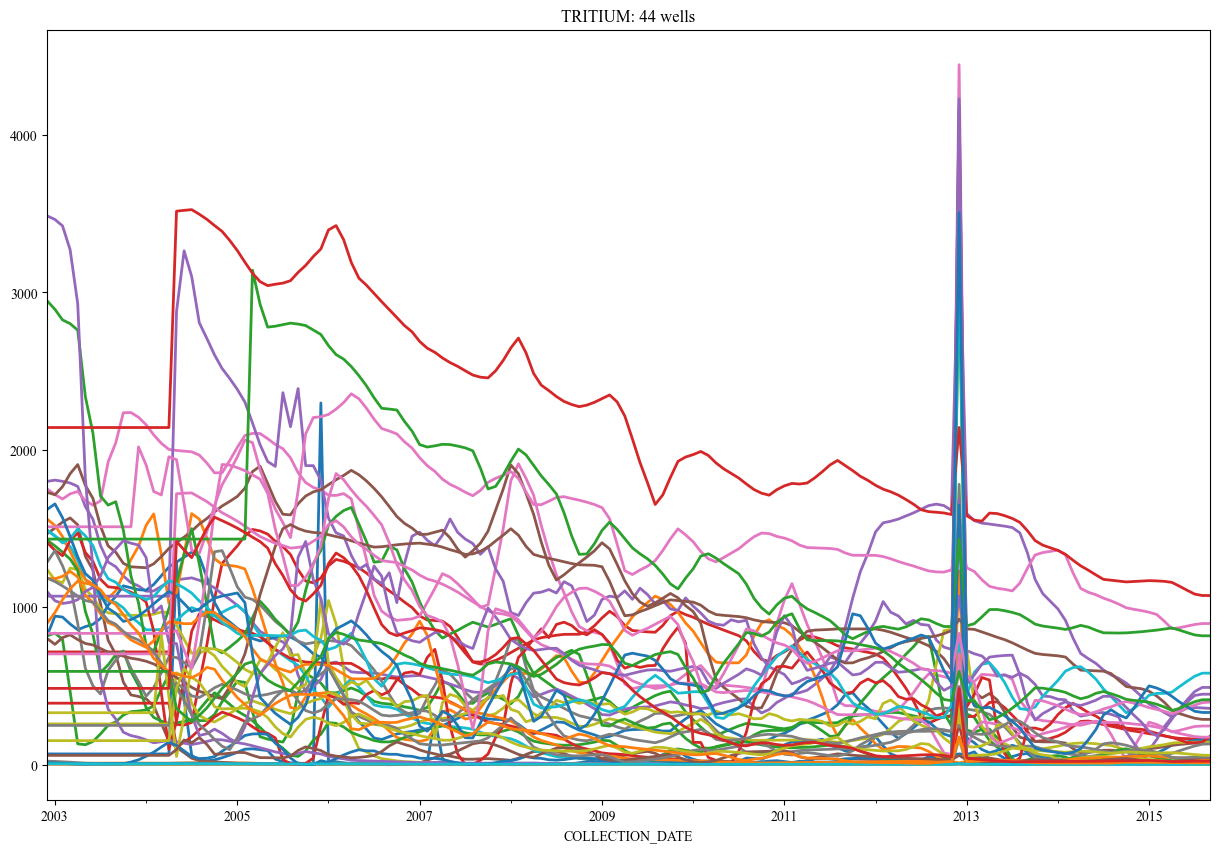

In [12]:
from pylenm2.data import filters

active = list(np.unique(filters.filter_by_column(
    pylenm2_dm.get_construction_data(), 
    col='WELL_USE', 
    equals=['ACTIVE'],
).index))

upper_wells = list(np.unique(filters.filter_by_column(
    pylenm2_dm.get_construction_data(), 
    col='AQUIFER', 
    equals=['UAZ_UTRAU'],
).index))

well_only_D = list(set(upper_wells) & set(tr_interp.columns) & set(well_enough)& set(well_recent)& set(well_old) & set(active))

tr_interp = tr_interp[well_only_D]
tr_interp.plot(figsize=(15,10), legend=False, linewidth=2, title=str(analyte + ": {} wells".format(tr_interp.shape[1])))

print(tr_interp.shape[1], "wells")

Let's remove the 'bad' time series wells

In [13]:
# bad_ones = ['FSB 89D', 'FSB128D', 'FSB104D', 'FSB 91D', 'FSB 99D']
bad_ones = ['FSB 89D', 'FSB128D', 'FSB104D', 'FSB 91D', 'FSB 99D', 'FSB117D']
tr_interp = tr_interp.drop(columns=bad_ones)
sc_interp = sc_interp.drop(columns=bad_ones)

In [14]:
# Reorder columns to be in alphabetical order
tr_interp = tr_interp.reindex(sorted(tr_interp.columns), axis=1)
sc_interp = sc_interp.reindex(sorted(sc_interp.columns), axis=1)

38 wells


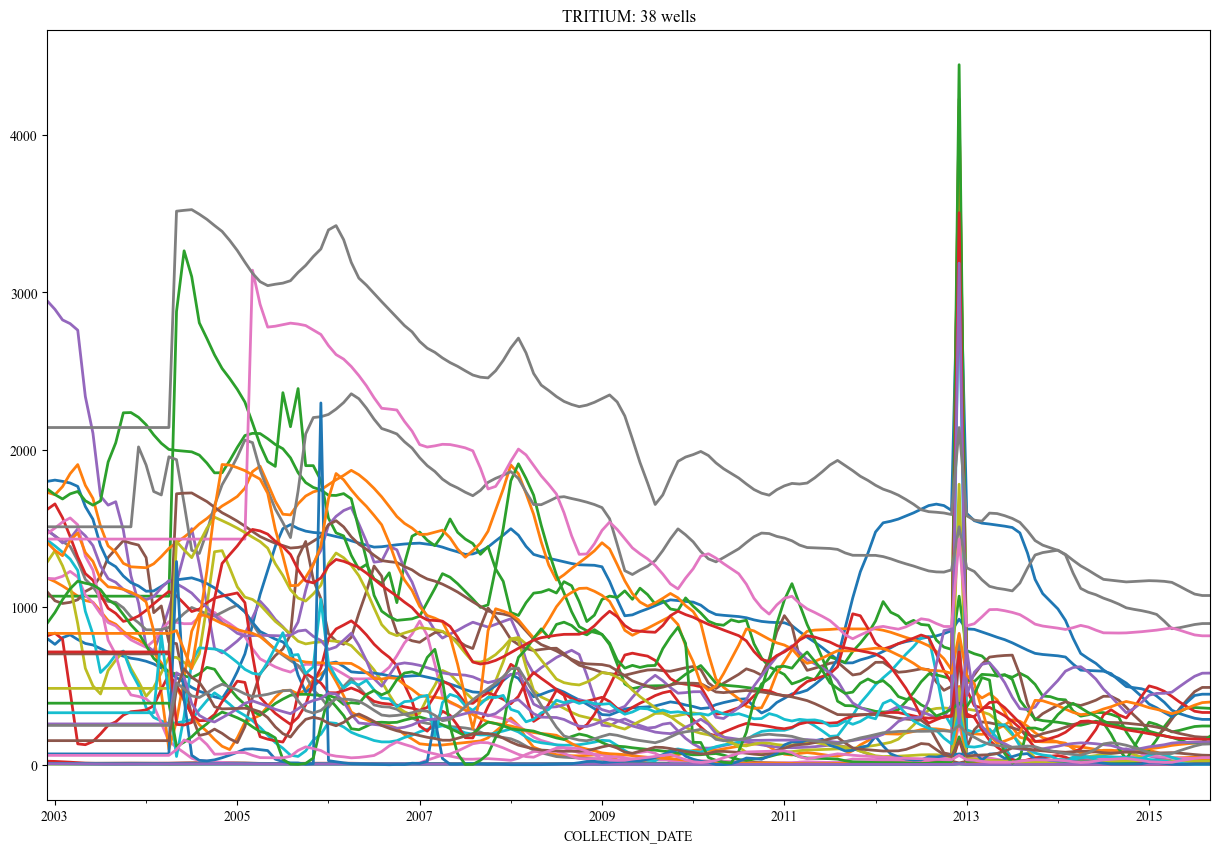

In [15]:
tr_interp.plot(
    figsize=(15,10), 
    legend=False, 
    linewidth=2, 
    title=str(analyte + ": {} wells".format(tr_interp.shape[1])),
)
print(tr_interp.shape[1], "wells")

## Well Location Data

In [16]:
well_info = pylenm2_dm.get_construction_data()

Match the well indecies between the time series and locations

In [17]:
shared_wells = list(set(well_info.index) & set(tr_interp.columns) & set(sc_interp.columns))
tr_interp = tr_interp[shared_wells]
sc_interp = sc_interp[shared_wells]
# Reorder columns to be in alphabetical order
tr_interp = tr_interp.reindex(sorted(tr_interp.columns), axis=1)
sc_interp = sc_interp.reindex(sorted(sc_interp.columns), axis=1)

well_info = well_info.T[shared_wells]
# Reorder columns to be in alphabetical order
well_info = well_info.reindex(sorted(well_info.columns), axis=1)
well_info = well_info.T

In [18]:
tr_interp.columns == sc_interp.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [19]:
crs = CRS.from_epsg("26917")
proj = Transformer.from_crs(crs.geodetic_crs, crs)
UTM_x, UTM_y = proj.transform(well_info.LATITUDE,well_info.LONGITUDE)

Take out the ground-surface elevation, and compute the water table elevation

In [20]:
elev = well_info.REFERENCE_ELEVATION
elev.index = well_info.index
elev = elev.T
elev = elev * 0.3048 # convert to meters

In [21]:
X = np.vstack((UTM_x,UTM_y, elev.values)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation'])

In [22]:
tr_interp.describe().T['min'].min()

0.001

In [23]:
tr_interp_org = tr_interp.copy()

In [24]:
# tr_interp = np.log2(tr_interp)
# sc_interp = np.log2(sc_interp)
tr_interp = np.log10(tr_interp)
sc_interp = np.log10(sc_interp)

In [25]:
tr_interp

,FBI 14D,FEX 4,FOB 14D,FSB 76,FSB 78,FSB 79,FSB 87D,FSB 88D,FSB 90D,FSB 92D,...,FSB127D,FSB130D,FSB131D,FSB132D,FSB133D,FSB134D,FSB135D,FSB136D,FSB137D,FSB138D
COLLECTION_DATE,,,,,,,,,,,,,,,,,,,,,
2002-12-31,2.903470,3.073748,3.029702,1.345864,3.469215,3.040357,3.073299,3.172342,3.110229,3.154120,...,2.685763,2.518814,1.835962,2.921354,2.592106,2.855247,2.413528,2.184636,1.774329,2.397454
2003-01-31,2.883579,3.065745,3.029702,1.321573,3.461340,3.017729,3.072355,3.162549,3.133493,3.143041,...,2.685763,2.518814,1.835962,2.921354,2.592106,2.855247,2.413528,2.184636,1.774329,2.397454
2003-02-28,2.907120,3.055299,3.029702,1.271842,3.451142,3.010488,3.078057,3.151755,3.101661,3.130334,...,2.685763,2.518814,1.835962,2.921354,2.592106,2.855247,2.413528,2.184636,1.774329,2.397454
2003-03-31,2.916618,3.043180,3.029702,1.206826,3.447495,3.013539,3.089296,3.142014,3.056071,3.116165,...,2.685763,2.518814,1.835962,2.921354,2.592106,2.855247,2.413528,2.184636,1.774329,2.397454
2003-04-30,2.900456,3.029739,3.029702,1.109511,3.440992,3.020377,3.076622,3.112847,2.952296,3.091439,...,2.685763,2.518814,1.835962,2.921354,2.592106,2.855247,2.413528,2.184636,1.774329,2.397454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-05-31,2.512092,1.647505,2.525093,0.623749,1.328347,2.550642,1.627977,0.744745,1.388463,1.510521,...,1.301898,1.015173,0.350033,2.529695,2.199687,2.224723,2.151092,1.866905,1.385054,1.947706
2015-06-30,2.491011,1.661813,2.556686,0.592033,1.275497,2.614463,1.609353,0.751952,1.417157,1.307672,...,1.329032,0.730962,0.452774,2.555351,2.148997,2.218839,2.153529,1.838239,1.512473,2.018423
2015-07-31,2.470190,1.674861,2.560355,0.563465,1.219094,2.667013,1.593061,0.758628,1.441211,0.950823,...,1.351852,0.471606,0.729888,2.578188,2.142598,2.213227,2.155810,1.809412,1.605654,2.075871


In [26]:
sc_interp

,FBI 14D,FEX 4,FOB 14D,FSB 76,FSB 78,FSB 79,FSB 87D,FSB 88D,FSB 90D,FSB 92D,...,FSB127D,FSB130D,FSB131D,FSB132D,FSB133D,FSB134D,FSB135D,FSB136D,FSB137D,FSB138D
COLLECTION_DATE,,,,,,,,,,,,,,,,,,,,,
2003-12-31,2.613993,2.556028,2.759229,1.589665,2.848233,2.735505,2.658755,2.740165,2.577951,2.811619,...,2.498496,2.414408,2.243538,2.652721,2.631166,2.583056,2.333511,2.295712,1.936727,2.223377
2004-01-31,2.608984,2.541587,2.759229,1.588854,2.773101,2.727069,2.650379,2.730878,2.577526,2.791469,...,2.498496,2.414408,2.243538,2.652721,2.631166,2.583056,2.333511,2.295712,1.936727,2.223377
2004-02-29,2.601594,2.519685,2.759229,1.599265,2.747650,2.620886,2.665698,2.725822,2.601708,2.760136,...,2.498496,2.414408,2.243538,2.652721,2.631166,2.583056,2.333511,2.295712,1.936727,2.223377
2004-03-31,2.590268,2.484610,2.759229,1.614428,2.758347,2.614613,2.688976,2.718567,2.636732,2.708304,...,2.498496,2.538448,2.243538,2.652721,2.631166,2.583056,2.333511,2.295712,1.936727,2.223377
2004-04-30,2.576670,2.439754,2.759229,1.627514,2.770638,2.620188,2.707270,2.712351,2.672116,2.651227,...,2.498496,2.448427,2.243538,2.652721,2.631166,2.583056,2.333511,2.295712,1.936727,2.223377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-05-31,2.606577,1.778699,2.491828,1.645299,2.432293,2.518458,2.018206,1.899787,2.461173,2.220556,...,1.750419,2.068366,1.711280,2.605223,2.309896,2.377118,1.762022,2.192689,1.841985,2.077973
2015-06-30,2.590457,1.743818,2.506279,1.634099,2.419000,2.479904,2.011121,1.905714,2.422070,2.182659,...,1.753082,2.018770,1.705436,2.630628,2.260687,2.359865,2.052838,2.203526,1.894870,2.119476
2015-07-31,2.574663,1.708086,2.507406,1.624356,2.406061,2.440054,2.005012,1.911238,2.383730,2.143550,...,1.755456,1.950261,1.650620,2.653329,2.253015,2.342916,2.217484,2.213518,1.939519,2.155336


In [27]:
# GETS APPROXIMATE tr VALUE IN THE XX GRID
def get_approx_predictions(X, y_map, XX):
    X_approx, y_approx = [],[]
    
    for i in range(X.shape[0]):
        x1, y1 = X.iloc[i].Easting, X.iloc[i].Northing # ACTUAL POINT
        abs_east = np.abs(XX.Easting-x1)
        abs_north= np.abs(XX.Northing-y1)
        c = np.maximum(abs_north,abs_east)
        index = np.argmin(c)
        XX.iloc[index].Easting, XX.iloc[index].Northing
        X_approx.append([XX.iloc[index].Easting, XX.iloc[index].Northing, XX.iloc[index].Elevation])
        y_approx.append(y_map[index])
    
    X_approx = pd.DataFrame(
        X_approx, 
        columns=['Easting', 'Northing', 'Elevation'],
    )
    
    return X_approx, y_approx

In [28]:
X = np.vstack((UTM_x,UTM_y, elev.values)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation'])

XX = np.vstack([x_loc.flatten(), y_loc.flatten(), farea_dem.flatten(), slope.flatten(), accum.flatten()]).T
XX = pd.DataFrame(XX, columns=['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'])

X_approx, Slope_X = get_approx_predictions(X, slope.flatten(), XX)
X_approx, Acc_X = get_approx_predictions(X, accum.flatten(), XX)

X = np.vstack((UTM_x,UTM_y, elev.values, Slope_X, Acc_X)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation', 'Slope', 'Acc'])

MSE:  0.1422193097434501
R^2:  0.8326630311530376


/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_23401/2117738449.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


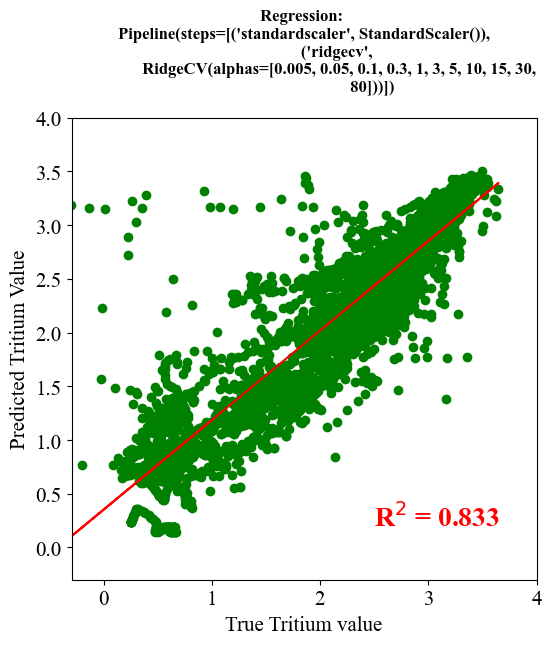

In [29]:
from pylenm2.stats import metrics

tr_all = tr_interp.iloc[12:,:].values.flatten()
sc_all = sc_interp.values.flatten()

X_train, X_test, y_train, y_test = train_test_split(sc_all, tr_all, test_size=0.2, random_state=365)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

alpha_Values = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
reg = make_pipeline(StandardScaler(), RidgeCV(alphas=alpha_Values))

reg.fit(X=X_train, y=y_train)
predicted_tr = reg.predict(X_train)

fig, ax = plt.subplots(figsize=(6,6),dpi=100)
# plt.rcParams["legend.loc"] = 'upper left'
print("MSE: ", metrics.mse(y_train, predicted_tr))
r2 = r2_score(y_train, predicted_tr)
print("R^2: ",r2)
fontsize = 15
ax.set_title('Regression: \n{}'.format(reg), y=1.04, fontweight='bold')
ax.set_xlabel('True Tritium value',fontsize=fontsize)
ax.set_ylabel('Predicted Tritium Value', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim([-0.3, 4])
ax.set_ylim([-0.3, 4])
scatter1 = ax.scatter(y_train, predicted_tr, label = "Linear Regression + GP", c='g')

m_lr, b_lr = np.polyfit(y_train.flatten(), predicted_tr.flatten(), 1)

ax.plot(y_train, m_lr*y_train + b_lr, c='r')
ax.text(2.5,0.2,"R{} = {:.3f}".format('$^{2}$' ,r2), c='r', fontsize=20, fontweight='bold')
fig.show()
# PLOTS TRAINING SET

Correlation between the 38 average values: 0.913


/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_23401/3253456595.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


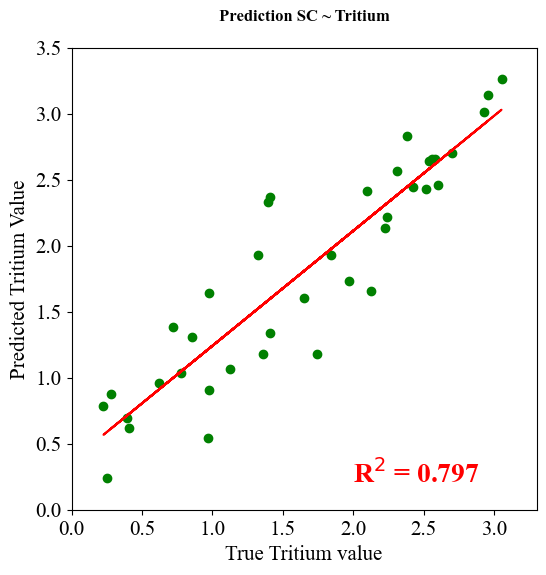

In [30]:
year = 2015
y_sc = np.array(sc_interp.loc[sc_interp.index[pd.Series(sc_interp.index).dt.year == year]].mean())
y_tr = np.array(tr_interp.loc[tr_interp.index[pd.Series(tr_interp.index).dt.year == year]].mean())

print("Correlation between the {} average values: {:0.3}".format(y_sc.shape[0],np.corrcoef(y_sc, y_tr) [0][1]))

# Predict TRITIUM based on SC average values
y_tr_pred = reg.predict(y_sc.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(6,6),dpi=100)

ax.set_title('Prediction SC ~ Tritium', y=1.04, fontweight='bold')
ax.set_xlabel('True Tritium value',fontsize=fontsize)
ax.set_ylabel('Predicted Tritium Value', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim([0, 3.3])
ax.set_ylim([0, 3.5])

scatter1 = ax.scatter(y_tr, y_tr_pred, label = "Linear Regression + GP", c='g')

m_lr, b_lr = np.polyfit(y_tr.flatten(), y_tr_pred.flatten(), 1)

ax.plot(y_tr, m_lr*y_tr + b_lr, c='r')
ax.text(2,0.2,"R{} = {:.3f}".format('$^{2}$' ,r2_score(y_tr, y_tr_pred)), c='r', fontsize=20, fontweight='bold')
fig.show()

In [31]:
def dist(p1,p2):
    return sqrt(((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2))

def add_dist_to_basin(XX, basin_coordinate=[436642.70,3681927.09], col_name='dist_to_basin'):
    x1,y1 = basin_coordinate
    distances = []
    for i in range(XX.shape[0]):
        x2,y2 = XX.iloc[i][0], XX.iloc[i][1]
        distances.append(dist([x1,y1],[x2,y2]))
    XX[col_name] = distances
    return XX

In [32]:
b_c=[436642.70,3681927.09]
XX = add_dist_to_basin(XX, basin_coordinate=b_c)
X = add_dist_to_basin(X, basin_coordinate=b_c)

In [33]:
print(y_tr)
print(y_tr_pred.flatten())

[2.5377152  1.73972904 2.42145596 0.61874604 1.39505552 2.51289214
 1.6475616  0.72357937 1.40841397 1.32400839 2.58197849 2.09403204
 2.37735159 2.60385993 2.70227327 0.85258422 0.3950617  2.95583734
 0.22681089 0.25043046 0.404937   0.97724643 1.12601957 0.96527693
 0.27689561 2.30712207 2.92608084 3.0514239  1.35560232 0.97612596
 0.77709346 2.5562661  2.22587754 2.23894009 2.12815083 1.84184242
 1.40756846 1.96777647]
[2.63894789 1.1787343  2.44130103 0.96243    2.33380102 2.4264445
 1.60295952 1.38478477 2.37244171 1.92935518 2.65535863 2.41627029
 2.83222015 2.45847423 2.70471987 1.30533275 0.69241729 3.14536184
 0.782537   0.24007374 0.61681105 0.90683899 1.06750426 0.5443034
 0.87750739 2.5665948  3.01112125 3.26360431 1.17602122 1.64343686
 1.03408386 2.65602995 2.13535391 2.21815183 1.65584717 1.92755341
 1.34148649 1.73110382]


In [34]:
from pylenm2.stats import gp as stats_gp

from sklearn.exceptions import ConvergenceWarning
import warnings
for msg in WARNING_MESSAGES_TO_IGNORE:
    warnings.filterwarnings(
        "ignore", 
        message=msg,
    )
    warnings.filterwarnings(
        "ignore",
        category=ConvergenceWarning,
    )


# TRUE
y_map_true_tr, r_map, residuals, trend = stats_gp.interpolate_topo(X, y_tr, XX, ft=['Easting', 'Northing', 'Elevation', 'dist_to_basin'], regression='linear', smooth=True) 

# PREDICTED
y_map_pred_tr, r_map, residuals, trend = stats_gp.interpolate_topo(X, y_tr_pred.flatten(), XX, ft=['Easting', 'Northing', 'Elevation', 'dist_to_basin'], regression='linear', smooth=True) 

y_map_true_tr[y_map_true_tr < 0] = 0
y_map_pred_tr[y_map_pred_tr < 0] = 0

NameError: name 'WARNING_MESSAGES_TO_IGNORE' is not defined

/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_8829/1689642442.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.7879163142684993


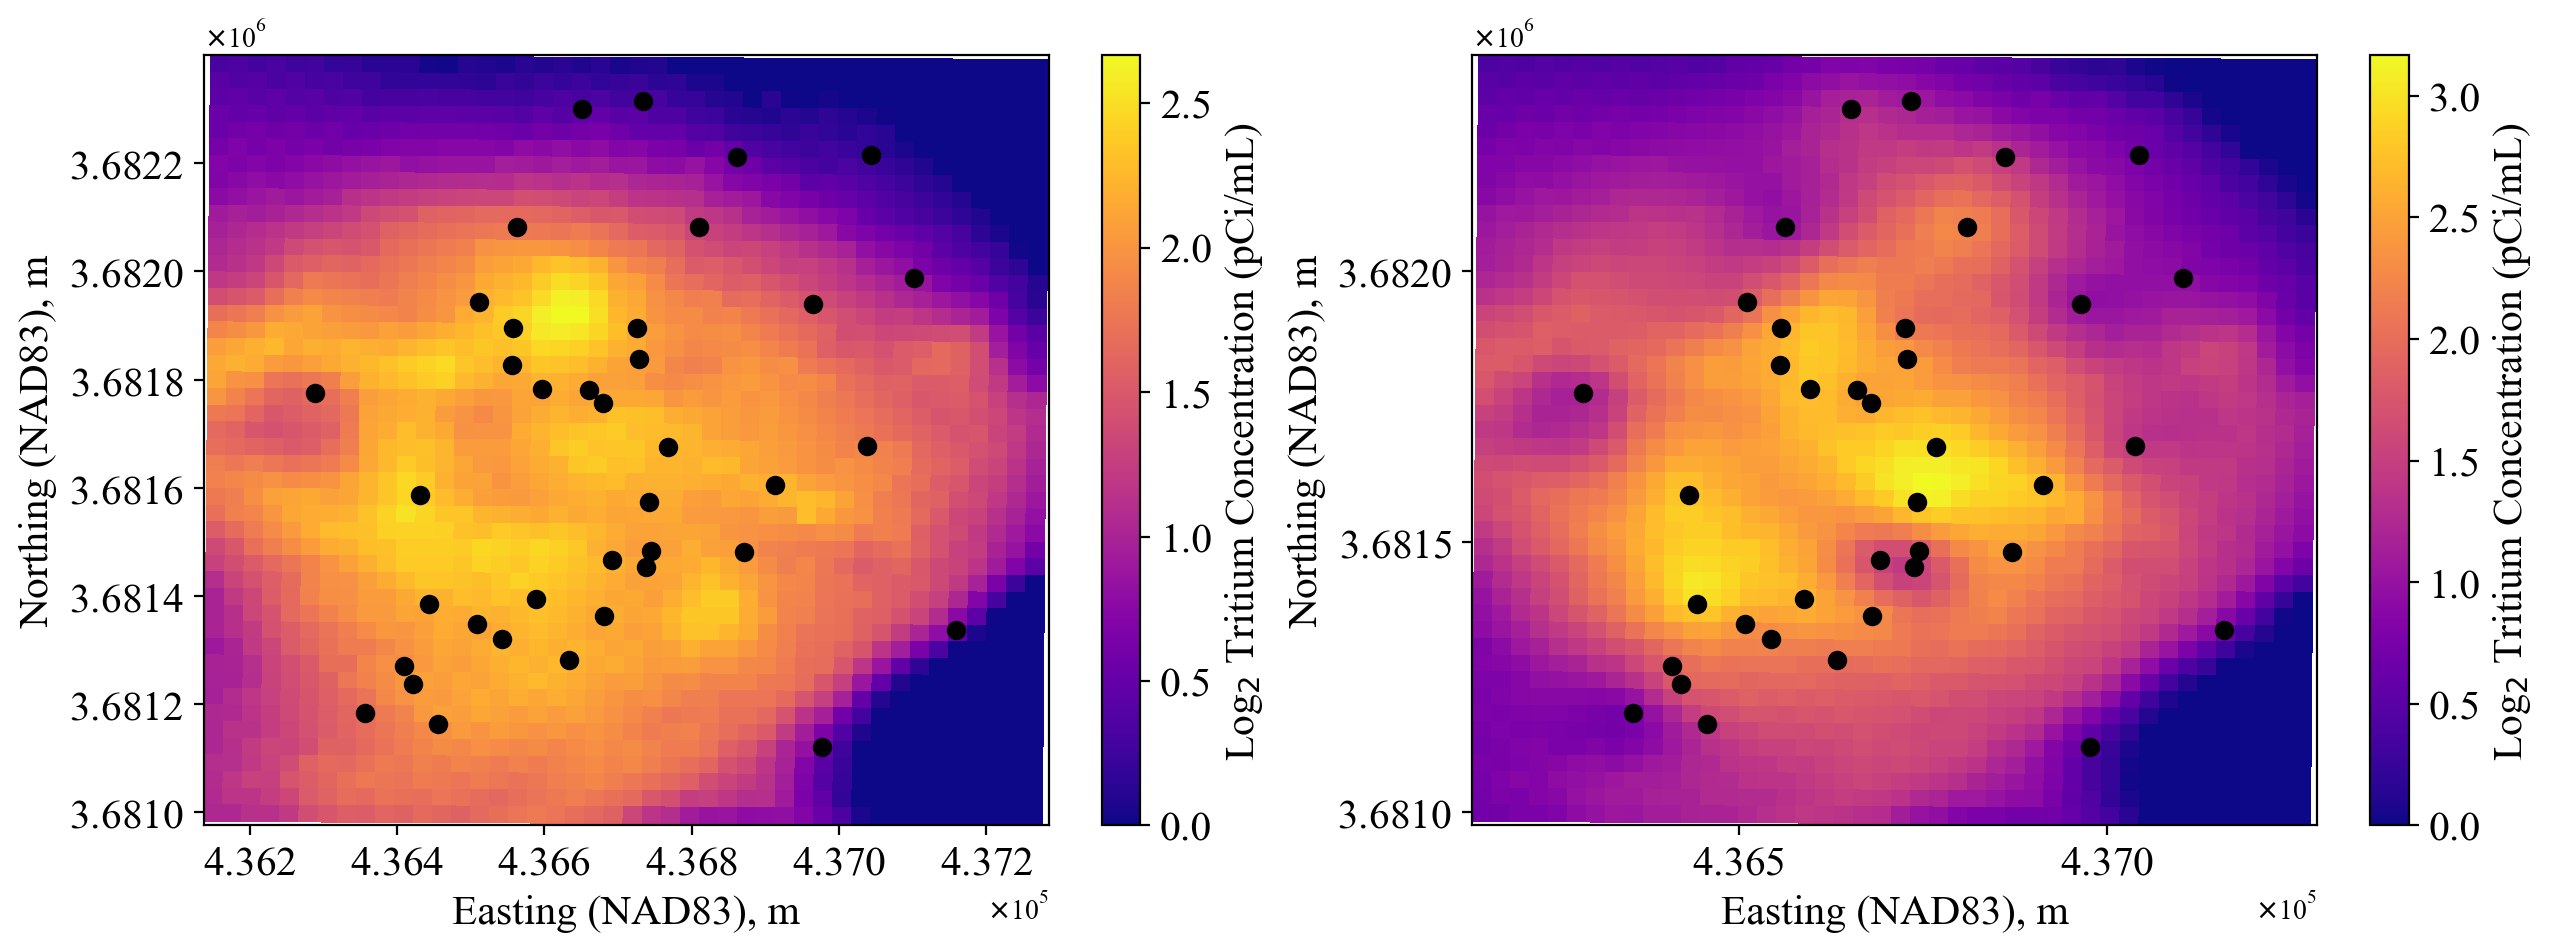

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=200)
plt.rc('font', size=fontsize)
# plt.locator_params(axis='both', nbins=4, tight=False)
xx = np.array(XX)
titles = [str("Linear Regression + Kriging\n Log{} Tritium Reference Field | Averaged {}".format('$_{2}$',year,)), str("Using SC as a Proxy to Tritium\nLinear Regression + Kriging\n Log{} Tritium Reference Field | Averaged {}".format('$_{2}$',year,))]

map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map_true_tr.reshape(x_loc.shape), 
                cmap='plasma')
                # vmin=y_map_pred_tr.min(), vmax=y_map_pred_tr.max())
fig.colorbar(map_0, ax=ax[0]).set_label(label="Log{} Tritium Concentration ({})".format('$_{2}$', pylenm2_dm.get_unit('TRITIUM')), size=fontsize)

map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map_pred_tr.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax[1]).set_label(label="Log{} Tritium Concentration ({})".format('$_{2}$', pylenm2_dm.get_unit('TRITIUM')), size=fontsize)

here = ax[1]
# ax[0].scatter(X.iloc[:,0], X.iloc[:,1], c=colors, alpha=1)

for i in range(2):
    ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=1)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i].set_xlabel("Easting (NAD83), m", fontsize=fontsize)
    ax[i].set_ylabel("Northing (NAD83), m", fontsize=fontsize)
    # ax[i].set_title(titles[i],y=1.04,fontweight='bold')
    ax[i].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)

plt.locator_params(axis='x', nbins=4, tight=False)
plt.locator_params(axis='y', nbins=4, tight=False)
print(r2_score(y_map_true_tr, y_map_pred_tr))

fig.show()

/var/folders/4f/fztycq7j0wj0t_2bhzck543c0000gp/T/ipykernel_8829/4077500978.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


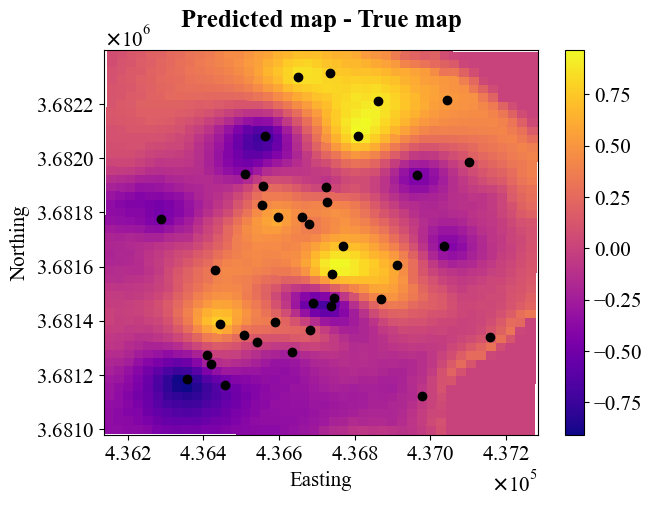

In [ ]:
y_diff = y_map_pred_tr.flatten() - y_map_true_tr.flatten()
fig, ax = plt.subplots(figsize=(7,5), dpi=100)
xx = np.array(XX)
title = 'Predicted map - True map'

map_0 = ax.pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_diff.reshape(x_loc.shape), 
                cmap='plasma',)
                # vmin=y_map_true_tr.min(), vmax=y_map_true_tr.max())
fig.colorbar(map_0, ax=ax)

ax.scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=1)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_title(title,y=1.04,fontweight='bold')
ax.ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)

fig.show()